In [516]:
# ! pip install --upgrade pip
# ! pip install --upgrade numpy scipy matplotlib pyhf cabinetry uproot pandas

In [517]:
import numpy as np
import cabinetry
import pyhf
import json
from pathlib import Path

cabinetry.__version__

'0.5.2'

# Building the model

`Cabinetry` has the nice feature that it can crate `pyhf` models from `root` files. 

First we need to chose our fitting variable and the binning. Here we chose to fit in 50 bins of $\Delta E$.

In [518]:
bins = np.linspace(-0.4, 0.4, 20 + 1)

We define `cabinetry` models vie a `config` dictionary, containing different settings:

First, we give our measurement a name, denife a parameter of interest (POI), and input path containing the `root` files and a histogram folder, where cabinetry automatically saves the historgam yields.

In [519]:
cabinetry.set_logging()

BASE = Path('/home/belle/zhangboy/Summer_workshop_2023/Ntuples')

config = {
   "General":{
      "Measurement": "B2Kpi0",
      "POI": "norm_signal",
      "InputPath": str(BASE / "{SamplePath}"), # wildcard for samples
      "HistogramFolder": "histograms/"

   }
}

Int the `Regions` setting, we tell `cabinetry` which variable in the `root` files it should load and define our signal region via the cut $| \Delta E | < 0.4 GeV$. It is a list, because we can use events from more than one phase space region. Additionally, we define the binning.

Next we can define our `Samples` again in a list, where we specify the name of each sample, the `root` file in the `InputPath`, the `Tree` and whether it is data or not. We can also pass a list of files as `SamplePath` and `cabinetry` will combine the files for us. 

In [520]:
config.update({
   "Regions":[
      {
         "Name": "signal_region",
         "Variable": "B_deltaE",             # which variable we bin histograms in
         "Filter": "(abs(B_deltaE)<0.4) & (B_R2<0.45)",           # event selection 
         "Binning": list(bins)
      }
   ]
})

config.update({
   "Samples":[
      {
         "Name": "Data",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_8/charged.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/mixed.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/ssbar.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/ccbar.root'],
         "Tree": "Bsig",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "signal",
         "SamplePath": ["MC15ri_b_Kpi0_signal_8/00.root"],
         "Tree": "Bsig",
         "Weight": '0.015'                 # weights: Monte Carlo integration, simulation correction etc.
      },
      {
         "Name": "qqbar",
         "Tree": "Bsig",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/ssbar.root',
                        'MC15ri_b_Kpi0_generic_200fb_9/ccbar.root'],
         # "Weight": "__weight__"
      },
       {
         "Name": "BBbar",
         "Tree": "Bsig",
         "Filter": "(B_mcErrors>0) & (B_mcErrors!=128) & (abs(B_deltaE)<0.4) & (B_R2<0.45)",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/charged.root',
                        'MC15ri_b_Kpi0_generic_200fb_9/mixed.root'],
         # "Weight": "__weight__"                 # weights: Monte Carlo integration, simulation correction etc.
      },
      {
         "Name": "misID",
         "Tree": "Bsig",
         "Filter": "(B_mcErrors==128) & (abs(B_deltaE)<0.4) & (B_R2<0.45)",
         "SamplePath": ["MC15ri_b_Kpi0_misID/misID.root"],
         "Weight": '0.001'                 # weights: Monte Carlo integration, simulation correction etc.
      }
   ]
})

Lastly, we can add some modifiers: 

First, we add some normalisation factors for the signal and background. Here, we specify our `POI`, `Signal_norm`.

Then we can add some other systematics.


In [521]:
config.update({
   "NormFactors":[
      {
         "Name": "norm_signal",
         "Samples": "signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10]
      },
      {
         "Name": "norm_qqbar",
         "Samples": "qqbar",
         "Nominal": 1,
         "Bounds": [-5, 10]
      },
      {
         "Name": "norm_BBbar",
         "Samples": "BBbar",
         "Nominal": 1,
         "Bounds": [-5, 10]
      },
      {
         "Name": "norm_misID",
         "Samples": "misID",
         "Nominal": 1,
         "Bounds": [-5, 10]
      }
   ]
})

config.update({
   "Systematics":[
   ],
})

`cabinetry` lets us validate our `config`,


In [522]:
cabinetry.configuration.validate(config)

True

Additionally, we can print an overview. We see that we have _ samples, _ regions, _ normalisation factors and _ systematics.

In [523]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   5 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   4 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


## Creating the histograms

Given that our validation succeeds, we can `build` the histrograms for our model. This will create the hisrograms from the `root` files and save them into the `HistogramFolder`.

In [524]:
cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - 

You can also provide existing histograms you built yourself for `cabinetry` to use, see the [cabinetry-tutorials](https://github.com/cabinetry/cabinetry-tutorials) repository for an example.

`Cabinetry` also allows us to apply post-processing to our histograms, which consists of a fix for `NaN` statistical uncertainties and optional smoothing. It will create new histogram files in the `HistogramFolder` folder with the `*_modified.npz` ending.

In [525]:
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal_modified.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar_modified.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar_modified.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variatio

We can now visualise what we produced:

INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


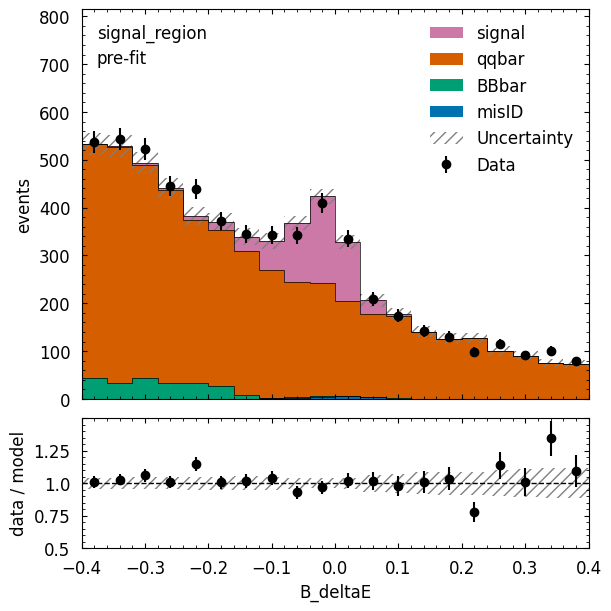

In [526]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

`cabinetry` will automatically save this image in a `/figures` folder.

# Adding systematics

## Tracking efficiency

We rerun the reconstruction, removing some tracks. The resulting ntuples contain slightly different yields which tell us about the systematic uncertainty due to the tracking efficiency. 

In `cabinetry`, adding these uncertainties is very easy. We just specify the up- and down-variations via the new `root` file. Here we tell the configuration to symmetrize the variation. Other settings, such as `Tree, Weight, Variable, Filter,...` are inherited (see https://cabinetry.readthedocs.io/en/latest/config.html#template).

The `NormPlusShape` corresponds to a `histosys` modifier plus a `normsys` modifier. The `histosys` modifier takes care of the normalized shape variation due to our new samples and the `normsys` modifier takes care of the normalization differences of our nomial sample and the the modified one. `Cabinetry` will give the modifiers the same name, which will tell `pyhf` that these modifiers are correlated. Hence we will only see 1 nuisance parameter per sample in this case.



In [527]:
config.update({
   "Systematics":[
      {
         "Name":"TrackingEfficiency_signal",
         "Up": {"SamplePath": "MC15ri_b_Kpi0_signal_rmT_4/sub00/grid_00000_job348357260_00.root"},
         "Down": {"Symmetrize": True},
         "Samples": "signal",
         "Type": "NormPlusShape"
      },
      {
         "Name":"TrackingEfficiency_qqbar",
         "Up": {
               "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/ssbar_rmT.root',
                              'MC15ri_b_Kpi0_generic_200fb_9/ccbar_rmT.root']
               },
         "Down": {"Symmetrize": True},
         "Samples": "qqbar",
         "Type": "NormPlusShape"
      },
      {
         "Name":"TrackingEfficiency_BBbar",
         "Up": {
               "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/charged_rmT.root',
                              'MC15ri_b_Kpi0_generic_200fb_9/mixed_rmT.root'] 
               },
         "Down": {"Symmetrize": True},
         "Samples": "BBbar",
         "Type": "NormPlusShape"
      },
      {
         "Name":"TrackingEfficiency_misID",
         "Up": {
               "SamplePath": ["MC15ri_b_Kpi0_misID/misID_rmT.root"]
               },
         "Down": {"Symmetrize": True},
         "Samples": "misID",
         "Type": "NormPlusShape"
      }
   ],
})

cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal.npz
DEBUG - cabinetry.route -       variation TrackingEfficiency_signal Up
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal_TrackingEfficiency_signal_Up.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz
DEBUG - cabinetry.route -       variation TrackingEfficiency_qqbar Up
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar_TrackingEfficiency_qqbar_Up.npz
DEBUG - cabinetry.route -     reading sam

# Building a `pyhf` workspace

We now construct a `pyhf` workspace, which contains everything to build our likelihood function. This can also be used as an input file for `pyhf`. 

In [528]:
workspace_path = "b2kpi_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor norm_signal to sample signal in region signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys TrackingEfficiency_signal to sample signal in region signal_region
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_signal_TrackingEfficiency_signal_Up_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - normalization impact of systematic TrackingEfficiency_signal on sample signal in region signal_region is 0.992
DEBUG - cabinetry.workspace - adding NormFactor norm_qqbar to sample qqbar in region signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys TrackingEfficiency_qqbar to sample qqbar in region signal_region
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_qqbar_TrackingEfficiency_qqbar_Up_modified.npz does not exist
WARNING 

In [529]:
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        1.6199999999999968,
                        2.4899999999999984,
                        3.8100000000000094,
                        5.804999999999972,
                        9.47999999999998,
                        16.755000000000255,
                        29.415000000000735,
                        60.75000000000192,
                        124.00500000000432,
                        181.34999999995594,
                        124.56000000000434,
                        27.345000000000656,
                        3.9600000000000106,
                        1.289999999999999,
                        0.6450000000000005,
                        0.27000000000000013,
                        0.2250000000000001,
                        0.12,
                        0.075,
                        0.06
                    ],
   

## Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues. The `visualize.modifier_grid` function creates a figure showcasing the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (20 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


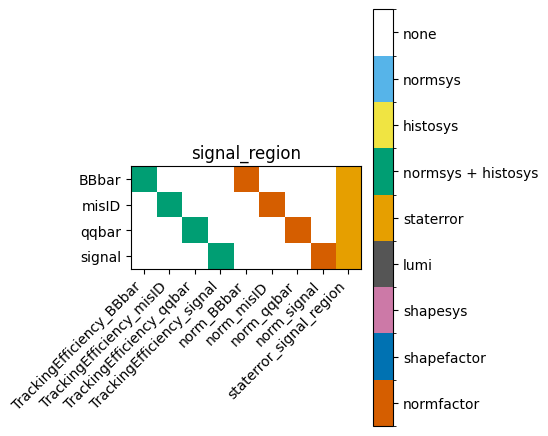

In [530]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

# Performing statistical inference

To perform inference, we need two things: a probability density function (pdf), or `model`, and data to fit it to. Both are derived from the workspace specification.

In [531]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (20 new nuisance parameters)


We see that all the modifiers that we defined for our model appear here.

## Validating the systematics 

First let us check that we indeed only get 1 nuisance paramter per sample for the `TrackingEfficiency` modifier:

In [532]:
model.config.par_names

['TrackingEfficiency_BBbar',
 'TrackingEfficiency_misID',
 'TrackingEfficiency_qqbar',
 'TrackingEfficiency_signal',
 'norm_BBbar',
 'norm_misID',
 'norm_qqbar',
 'norm_signal',
 'staterror_signal_region[0]',
 'staterror_signal_region[1]',
 'staterror_signal_region[2]',
 'staterror_signal_region[3]',
 'staterror_signal_region[4]',
 'staterror_signal_region[5]',
 'staterror_signal_region[6]',
 'staterror_signal_region[7]',
 'staterror_signal_region[8]',
 'staterror_signal_region[9]',
 'staterror_signal_region[10]',
 'staterror_signal_region[11]',
 'staterror_signal_region[12]',
 'staterror_signal_region[13]',
 'staterror_signal_region[14]',
 'staterror_signal_region[15]',
 'staterror_signal_region[16]',
 'staterror_signal_region[17]',
 'staterror_signal_region[18]',
 'staterror_signal_region[19]']

Next we want to verify the numeric variations for the signal region.
To check these variations, we load the signal region Up-variation histogram for the `TrackingEfficiency`, which corresponds to the yields of the modified sample. To compare, we also load the nominal yields.

In [533]:
tracking_nominal = np.load('histograms/signal_region_signal.npz')['yields']
tracking_modified = np.load('histograms/signal_region_signal_TrackingEfficiency_signal_Up.npz')['yields']

First let us check the `normsys` variations. We expect:

In [534]:
spec['channels'][0]['samples'][0]['modifiers'][2]

{'name': 'TrackingEfficiency_signal',
 'type': 'normsys',
 'data': {'hi': 0.9918943487702655, 'lo': 1.0081056512297346}}

Here `hi` and `lo` are just labels for the numbers we interpolate between. It does not matter is `lo` is larger than `hi`.

We can calculate these values as the ratio of the total number of (possibly weighted) events. Make sure you understand the origin of these numbers.

In [535]:
sum(tracking_modified)/sum(tracking_nominal)

0.9918943487702655

In [536]:
(2*sum(tracking_nominal) - sum(tracking_modified))/sum(tracking_nominal)

1.0081056512297344

Now let us check the `histosys` entries. We expect

In [537]:
spec['channels'][0]['samples'][0]['modifiers'][3]

{'name': 'TrackingEfficiency_signal',
 'type': 'histosys',
 'data': {'hi_data': [1.6181158829968634,
   2.5103480053970064,
   3.750399429749755,
   5.776824928082244,
   9.451611466103168,
   16.801184542145286,
   29.413414882513866,
   60.80788752832341,
   123.73293602505441,
   181.39532725740935,
   124.67053588249188,
   27.417234540872794,
   3.9772381049362338,
   1.3005417377357982,
   0.6502708688679001,
   0.27220641022377207,
   0.22683867518647668,
   0.12098062676612086,
   0.07561289172882553,
   0.06049031338306043],
  'lo_data': [1.6218841170031302,
   2.4696519946029905,
   3.8696005702502636,
   5.8331750719177,
   9.508388533896794,
   16.708815457855223,
   29.416585117487603,
   60.692112471680424,
   124.27706397495422,
   181.30467274250253,
   124.4494641175168,
   27.272765459128518,
   3.9427618950637875,
   1.2794582622641997,
   0.6397291311321008,
   0.2677935897762282,
   0.2231613248135235,
   0.11901937323387914,
   0.07438710827117447,
   0.0595096866

We calculate these numbers by calculating the differenced of the nominal yields to the correctly scaled modified ones.

In [538]:
scale = sum(tracking_modified)/sum(tracking_nominal)
tracking_modified/scale

array([1.61811588e+00, 2.51034801e+00, 3.75039943e+00, 5.77682493e+00,
       9.45161147e+00, 1.68011845e+01, 2.94134149e+01, 6.08078875e+01,
       1.23732936e+02, 1.81395327e+02, 1.24670536e+02, 2.74172345e+01,
       3.97723810e+00, 1.30054174e+00, 6.50270869e-01, 2.72206410e-01,
       2.26838675e-01, 1.20980627e-01, 7.56128917e-02, 6.04903134e-02])

In [539]:
2*tracking_nominal - tracking_modified / scale

array([1.62188412e+00, 2.46965199e+00, 3.86960057e+00, 5.83317507e+00,
       9.50838853e+00, 1.67088155e+01, 2.94165851e+01, 6.06921125e+01,
       1.24277064e+02, 1.81304673e+02, 1.24449464e+02, 2.72727655e+01,
       3.94276190e+00, 1.27945826e+00, 6.39729131e-01, 2.67793590e-01,
       2.23161325e-01, 1.19019373e-01, 7.43871083e-02, 5.95096866e-02])

Can you explain the origin of these formulae?

### Bonus: Also check the variations for the PID systematics

## Maximum likelihood estimate (MLE)

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [540]:
# pyhf.set_backend('numpy','scipy')
# parameters = pyhf.infer.mle.fit(data=data, pdf=model)
# parameters

In [541]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 91.46                      │             Nfcn = 1638              │
│ EDM = 1.42e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────────────────

The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results. 

In [542]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

TrackingEfficiency_BBbar: 0.030 +/- 0.992
TrackingEfficiency_misID: 0.001 +/- 0.993
TrackingEfficiency_qqbar: 0.409 +/- 0.958
TrackingEfficiency_signal: 0.006 +/- 0.993
norm_BBbar: 1.313 +/- 0.610
norm_misID: 3.479 +/- 5.132
norm_qqbar: 1.025 +/- 0.044
norm_signal: 0.839 +/- 0.173
staterror_signal_region[0]: 0.983 +/- 0.034
staterror_signal_region[1]: 0.994 +/- 0.033
staterror_signal_region[2]: 1.006 +/- 0.035
staterror_signal_region[3]: 0.983 +/- 0.036
staterror_signal_region[4]: 1.047 +/- 0.039
staterror_signal_region[5]: 0.984 +/- 0.038
staterror_signal_region[6]: 1.000 +/- 0.039
staterror_signal_region[7]: 1.019 +/- 0.039
staterror_signal_region[8]: 0.982 +/- 0.037
staterror_signal_region[9]: 1.000 +/- 0.033
staterror_signal_region[10]: 1.011 +/- 0.039
staterror_signal_region[11]: 0.988 +/- 0.058
staterror_signal_region[12]: 0.978 +/- 0.056
staterror_signal_region[13]: 0.996 +/- 0.063
staterror_signal_region[14]: 1.005 +/- 0.066
staterror_signal_region[15]: 0.871 +/- 0.066
staterro

It is helpful to visualize the fit results. Let's start with the pull plot showing us best-fit parameter results.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


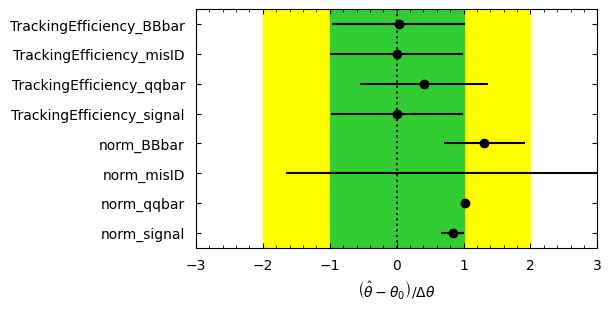

In [543]:
cabinetry.visualize.pulls(fit_results)

The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


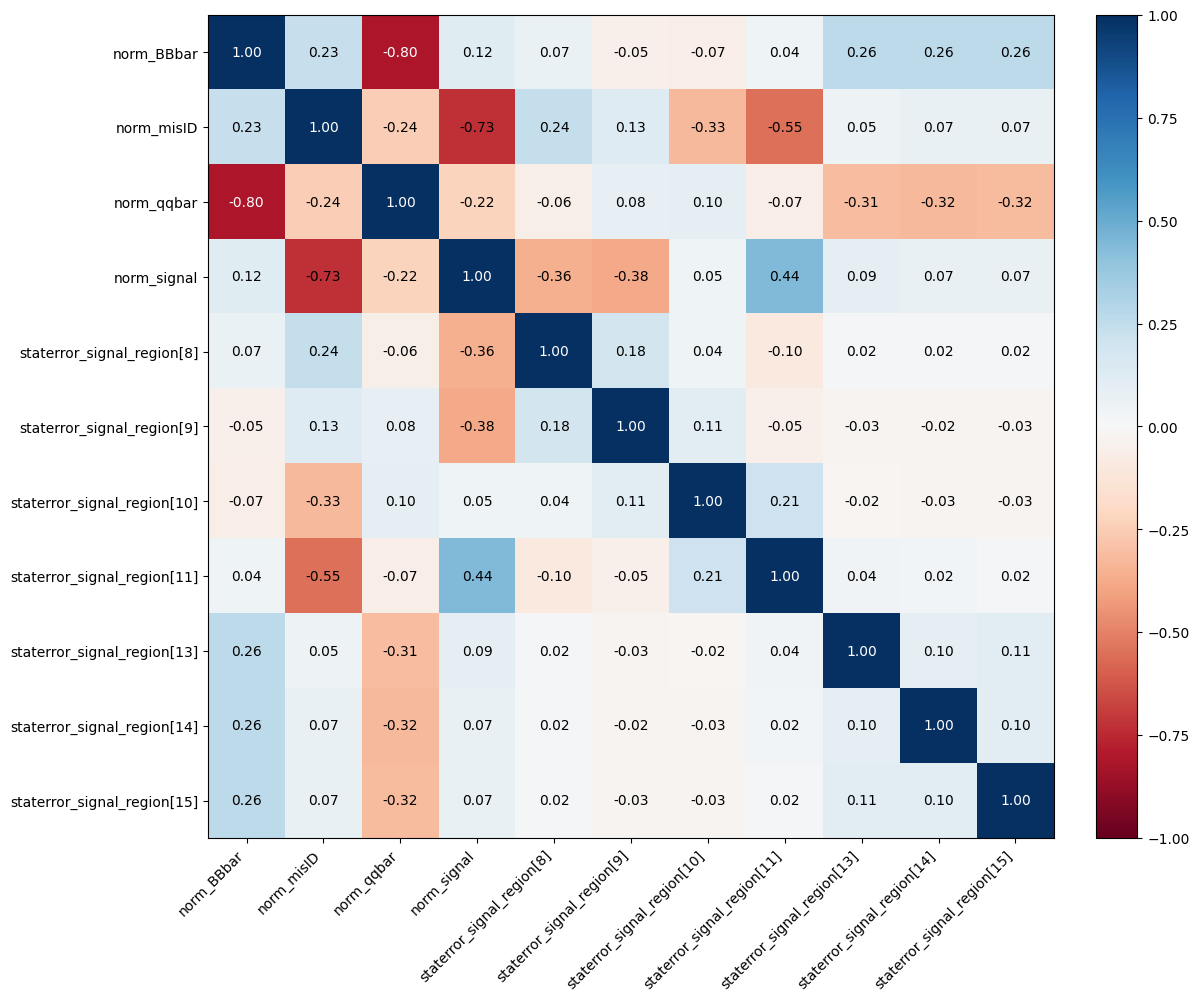

In [544]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.3)

Let us look at the post-fit result. This is as easy as passing `fit_results` to `cabinetry.model_utils.prediction`.

INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_postfit.pdf


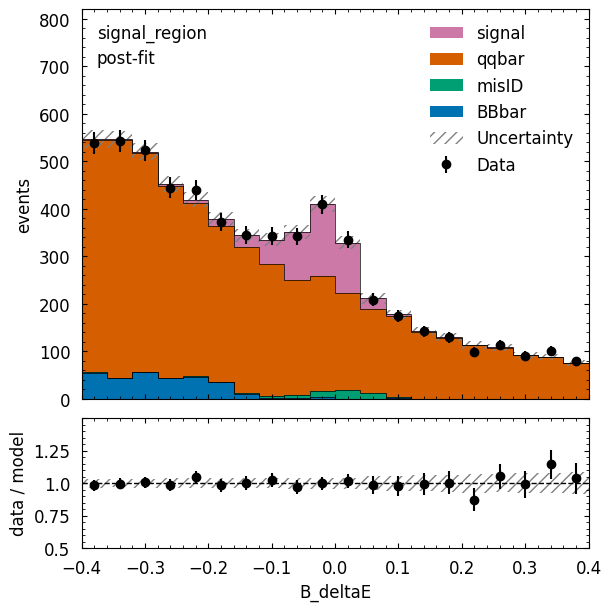

In [545]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)



Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default). The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.



In [546]:
model_pred = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒══════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤══════════════╤══════════════╤══════════════╕
│ sample   │ signal_region   │                │                │                │                │                │                │                │                │                │                │                │                │                │                │                │                │              │              │              │
│          │ bin 1           │ bin 2          │ bin 3          │ bin 4          │ bin 5          │ bin 6          │ bin 7          │ bin 8          │ bin 9          │ bin 10         │ bin 11         │ bin 12         │ bin 13       

# More advanced features

Here we provide a list of mor advanced features, for you to study if you have time. Most features are documented in one of these referenced:

* [`Cabinetry` Documentation](https://cabinetry.readthedocs.io/en/latest/index.html)
* [`Cabinetry` tutorial](https://github.com/cabinetry/cabinetry-tutorials/blob/master/example.ipynb)
* [Tutorial from Belle II `pyhf` workshop](https://github.com/alexander-held/Belle-II-cabinetry/blob/main/talk.ipynb)

## Asimov fit

If you do not have datapoints readily availible, a good first check if your fit works is a fit to Asimov data. Find out what Asimov data is and how to obtain it (cabinetry can do this). Then perform a fit to the Asimov data and see if you obtain what you expect.

## Likelihood scan

Perform a likelihood scan ouf our POI. This will tell you about the (asymmetric) uncertainty of the parameter. Does it agree with the uncertainty obtained in the fit above? It will also tell you if your likelihood scan agrees well with a Gaussian approximation. Does it in this case? Can you explain why?

## Parameter ranking

We can rank nuisance parameters by their impact on the POI: how much does the POI change if the NP varies within its uncertainty? How is this determined? (This requires a lot of MLE fits.)
